# Tuning Nueral Networks HyperParams

- We can try out different combinations of hyperparameters by using scikit-learn's GridSearchCV or RandomizedSearchCV

- To do that, we wrap the model in objects that mimic regular sklearn's regressors/classifiers
    - These are callables that build the model
    - Ex:
```
def build_model_fn(): ... return model
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model_fn)
keras_reg.fit(X_train, 
              y_train,
              epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test) # same as keras evaluate()
y_pred = keras_reg.predict(X_new)
```

- Since there are many hyperparameters, it is preferable to use a randomized search rather than grid search
```
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train,
                  y_train,
                  epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])
```

- RandomizedSearchCV uses K-fold cross-validation, so it does not use X_valid and y_valid, which are only used for early stopping

- this will most likely take hours
- when over you can find the best params using
```
>>> rnd_search_cv.best_params_
>>> rnd_search_cv.best_score_
>>> model = rnd_search_cv.best_estimator_.model
```

- this will most likely take hours
- when over you can find the best params using
```
>>> rnd_search_cv.best_params_
>>> rnd_search_cv.best_score_
>>> model = rnd_search_cv.best_estimator_.model
```

## Python Optimization Libraries
**Hyperopt**
- A popular library for optimizing over all sorts of complex search spaces (including real values, such as the learning rate, and discrete values, such as the number of layers).

**Hyperas, kopt, or Talos**
- Useful libraries for optimizing hyperparameters for Keras models (the first two are based on Hyperopt).

**Keras Tuner**
- An easy-to-use hyperparameter optimization library by Google for Keras models, with a hosted service for visualization and analysis.

**Scikit-Optimize (skopt)**
- A general-purpose optimization library. The BayesSearchCV class performs Bayesian optimization using an interface similar to GridSearchCV.

**Spearmint**
- A Bayesian optimization library.

**Hyperband**
- A fast hyperparameter tuning library based on the recent Hyperband paper23 by Lisha Li et al.

**Sklearn-Deap**
- A hyperparameter optimization library based on evolutionary algorithms, with a GridSearchCV-like interface.

# Choosing The Number of Layers

- For simple problems, a single-layer MLP can do the job most of the time
- For complex problems, deeper models have better parameter efficiency
    - This means they use less neurons to solve the problem

- Transfer Learning:
    - Deeper models can have reusable layers for other tasks
    - Freeze the lower layers, stack new layers on top, and train

# Num Neurons Per Layer

- Num neurons in input and output depends on task
    - MNIST = 28*28=784 input, 10 output

- Back in the day it was common to structure them in the form of a pyramind, with a smaller amount at each layer
    - Idea was that lower level features can coalesce into few upper layer feats
- This idea has been abandoned though, as using the same number in each hidden layer performs just as well, if not better

- However, with larger datasets, it is helpful to have the first hidden layer with a larger amount than the rest

- **"Stretch Pants" Approach:**
    - Pick an architecture with more layers and nuerons than you need and just use early stopping to prevent over fitting 

# Vanishing/Exploding/Unstable Gradients

- Backpropagation works from the output layer to the input layer, propagating the error gradient along the way
- Once the gradient of the cost function is computed w.r.t each parameter in the network, it uses the gradients to update each param with a Gradient Descent step.

### Vanishing
- Gradients get smaller and smaller as backprop progresses towards lower layers. So, the weights of these layers often are barely changed after the gradient descent step

### Exploding
- Gradients get larger and larger causing huge weight updates

### Unstable
- Certain layers learn at faster speeds than others

### Causes of Instability
- This caused DNNs to be abandonded in early 2000s, until a 2010 paper by Glorot and Bengio showed that the cause was the sigmoid activation function and the weight init popular at the time (a normal distribution (mean=0, std=1) 
    - https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

- They showed that with this weight init and activation fn, the the variance of the outputs in each layer tended to be much more than the inputs

- During the forward pass, the variance increases in each layer until the sigmoid fn saturates the top layers near 0 or 1

- So, when backprop kicks in, it has virtually no gradient to propagate back through the network
    - and what little gradient there does have gets diluted so the lower layers essentially have none

- This saturation is made worse because the logistic function has a mean of 0.5, not 0
    - the hyperbolic tangent function has a mean of 0 and behaves better than the logistic in DNNs

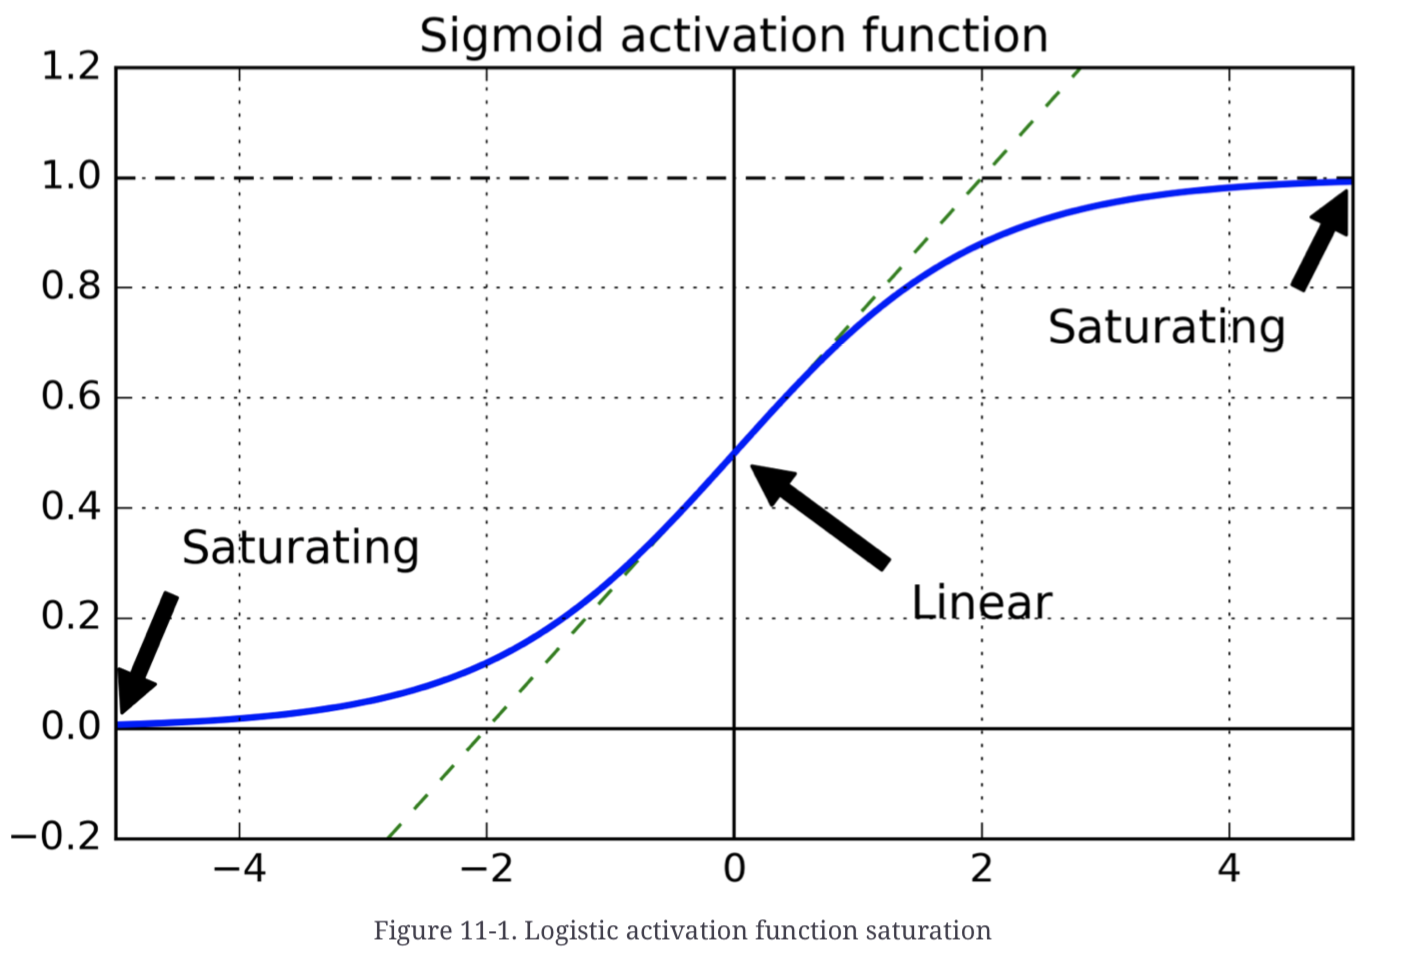

# Glorot / Xavier Initialization

- The paper says we need the signal to flow properly forward AND backward (no explosions, dying out, or instability)
- They say we need:
    - the variance of outputs equal to the variance of the inputs
    - the gradients to have equal variance before and after flowing through a layer in the reverse direction

- This isn't possible if the number of neurons aren't equal to the number of inputs (called fan in, fan out)

- However they came up with a solution that works well:
    - the weights in each layer must be initialized randomly whereby:
    ```
    fan_avg = (fan_in + fan_out)/2
    # normal dist
    mean = 0
    std = 1/fan_avg
    # uniform dist between -r and r
    r = sqrt(3/fan_avg)
    ```
- Note the above is only for logistic activation


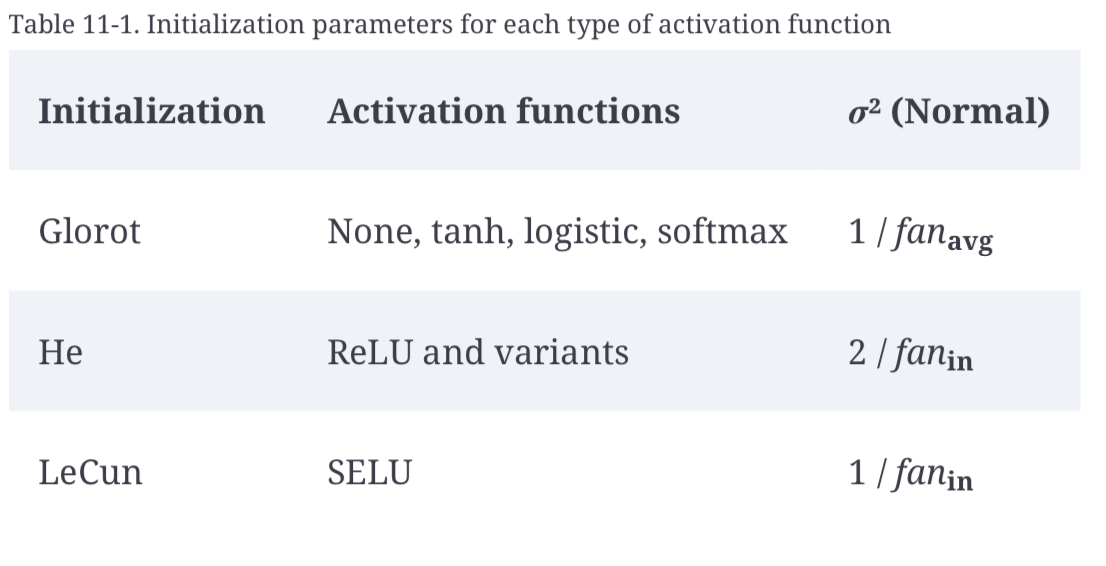

- By default, Keras uses Glorot initialization with a uniform distribution

- In Keras, you can change this by setting it as a param for the layer:
```
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")
```

- Can set your own with:
```
he_avg_init = keras.initializers.VarianceScaling(scale=2., 
                                                 mode='fan_avg',
                                                 distribution='uniform'
```

# Nonsaturating Activation Functions

- Up until Glorots paper, people assumed sigmoid would be best, as it was based on biological neurons

- ReLU however doesn't saturate for positive values, however it suffers from dying ReLUs, where neurons output nothing but zero
    - A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set

- Leaky ReLU solves this:
```
max(αz, z)
```
- Above, alpha determines how much it leaks, and is the slope for z < 0
    - defaulted to 0.01

- The below 2015 paper experimented with ReLU and variants of it and came to conclusion that LReLU variants outperformed ReLU
    - https://arxiv.org/abs/1505.00853
    - Setting a large leak (0.1-0.2) outperformed small leaks (0.01)

- Another 2015 paper (below) introduced the Exponential Linear Unit (ELU), which outperformed ReLU and its variants
    - https://arxiv.org/abs/1511.07289



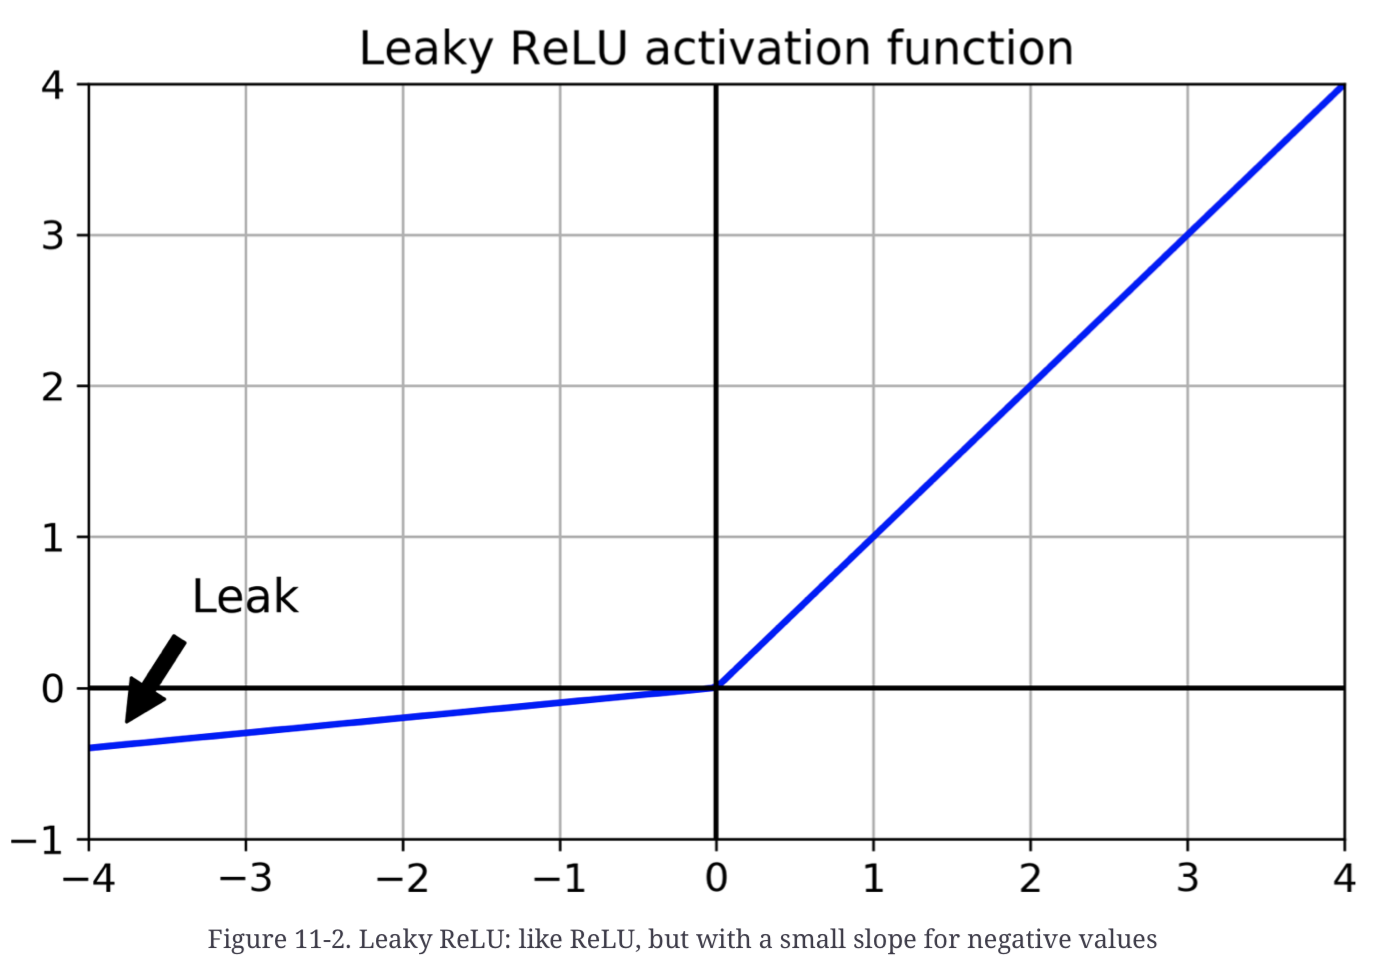

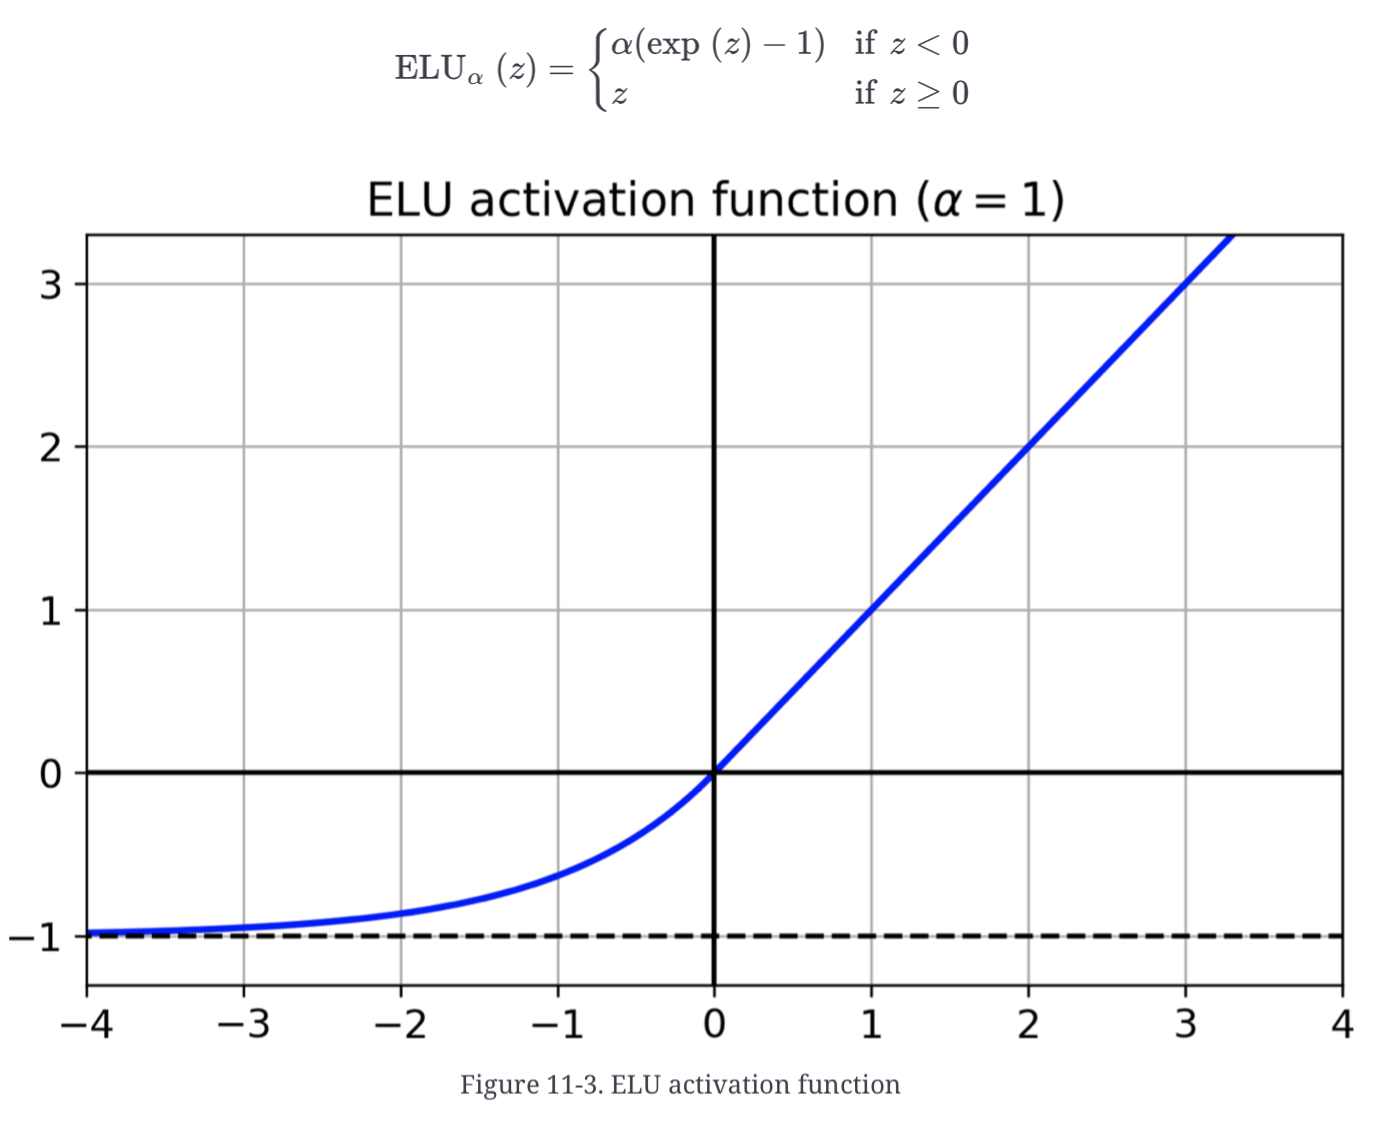

- ELU allows negative values when z < 0, which allows it to have an average output closer to 0, which helps alleviate the vanishing gradients problem, and prevents neurons from dying.

- alpha usually set to 1

- slower to compute than ReLU due to the exponentatiol operation, however it converges faster

### Scaled ELU (SELU)

- 2017 paper showed that a scaled variant of ELU can self-normalize a network (mean=0, std=1), which solves the vanishing/exploding gradient issue. 
- But only if some conditions are met:
    - all layers are dense (must be sequential -- no rnns, skip connections)
    - LeCun normal initialization
    - https://arxiv.org/abs/1706.02515


# Batch Normalization

- 2017 paper introduced batch normalization as a means to get rid of the vanishing/exploding gradients problem
    - https://arxiv.org/abs/1502.03167

- It involves placing an operation between layers that zero-centers and normalizes the input and then scales with a param vector and shifts with another param vector
    - So the network should learn the optimal scale
    - Placing this as the very first layer is like using StandardScaler preprocessing (on a batch level though)

- So, during training, BN standardizes its inputs, then rescales and offsets them

- The are four new param vectors learned:
    - Learned through regular backprop:
        - γ (the output scale vector)
        - β (the output offset vector)
    - Estimated Using a EWMA
        - μ (the final input mean vector)
        - σ (the final input standard deviation vector)

### Batch Norm During Testing

- However on test data data or when making predictions this can be an issue (might only be predicting for a few skewed examples for instance)

- To solve, Keras uses a moving average of the layer’s input means and standard deviations

- Improved performance on every network they tested, namely ImageNet

- Allows the use of logistic activation as it reduced the odds of vanishing/exploding gradients

- BN also acts like a regularizer, reducing the needs for others like dropout

```
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
```

- Authors argued the BN should be placed prior to activation function, not after, but that's debatable

```
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])
```

### Batch Norm Params

- momentum
    - usually set near 1, and is the variable in the ewma calculation
        - small batches or large dataset should be closer to 1

- axis
    - which axis to normalize
    - defaults to -1 (last axis)


# Gradient Clipping
    - https://arxiv.org/abs/1211.5063

- To mitigate the exploding gradients problem, we can clip the gradients during backprop so that they never exceed some threshold

- Mostly used with RNNs because BN is tricky to use with RNNs

- In Keras, we set it in the optimizer like so:
```
# clip every part of gradient vector to a value between (–1, 1)
optimizer = keras.optimizers.SGD(clipvalue=1.0)
```
- can also clipnorm which will preserve vector direction by scaling against clipped values. See the diff below:

- clipvalue
```
[0.9, 100.0] -> clipvalue=1 -> [0.9, 1.0]
```
-clipnorm
```
[0.9, 100.0] -> clipnorm=1 -> [0.0083, 1.0]
```


# Transfer Learning

- Authors tried many varients but only reported on the ones with the best results
- In reality, transfer learning works best of huge CNNs.
- For smaller nets, it can actually degrades performance

# Unsupervised Pretraining

- Used when there isn't much labeled data
- Idea is to use something like an auto-encoder or GAN, then utilize lower layers of either or which have already learned a representation of the data, and then fine tune





# Pretraining on an Auxiliary Task

- Again, if you dont have much labeled data:
    - Train on an auxillary task with lots of data, then reuse lower layers for the actual task

- NLP
    - download a corpus and automatically generate labeled data
        - ex: mask some random words and train to predict
    - reuse lower layers which learned about language for other tasks



# Faster Optimizers

Four ways to speed up training we've seen so far:
- initialization strategy for the connection weights
- Batch Norm
- Pretraining
- Good Activation Function


A 5th way is to have a faster optimizer.

### Momentum Optimization

Gradient Descent takes small, regular steps down the slope by:
- subtracting gradient of the cost function w.r.t weights and multiplying the learning rate 

Momentum Optimizers subtract the local gradient from the momentum vector (m) and (multiplied by the learning rate η) and updates by adding the vector
    - first introduced in 1967

- In physics terms, the gradient is used for acceleration, not for speed

- to add the concept of friction and prevent momentum from growing, a hyperparam β, called *the momentum*
    - set between 0 (high friction) and 1 (no friction).

- Momentum optimizers tend to overshoot a bit, then come back, and oscillate like this many times before stabilizing at the minimum.
    - This is the reason to have some friction -- to get rid of these oscillations and speed up convergence

```
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
```


# Nesterov Accelerated Gradient (NAG)

- faster than vanilla momentum optimization
- measures the gradient of the cost function not at the local position θ but slightly ahead in the direction of the momentum, at θ + βm
- this works because the momentum vector is pointing toward the optimum, so looking slightly ahead works at speeding up convergence

```
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
```


# AdaGrad

- Gradient Descent starts by going steeply down the slope, not pointing at the global optimumum, and then slowly reaches the bottom of the slope

- AdaGrad causes the gradient vector to point in the right direction earlier by scaling down the vector on the steepest dimension
    - https://jmlr.org/papers/v12/duchi11a.html

- Adaptive learning rate
    - The algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes

- Often stops too early when training NNs because the learning rate gets scaled down so much prior to reaching global optimum



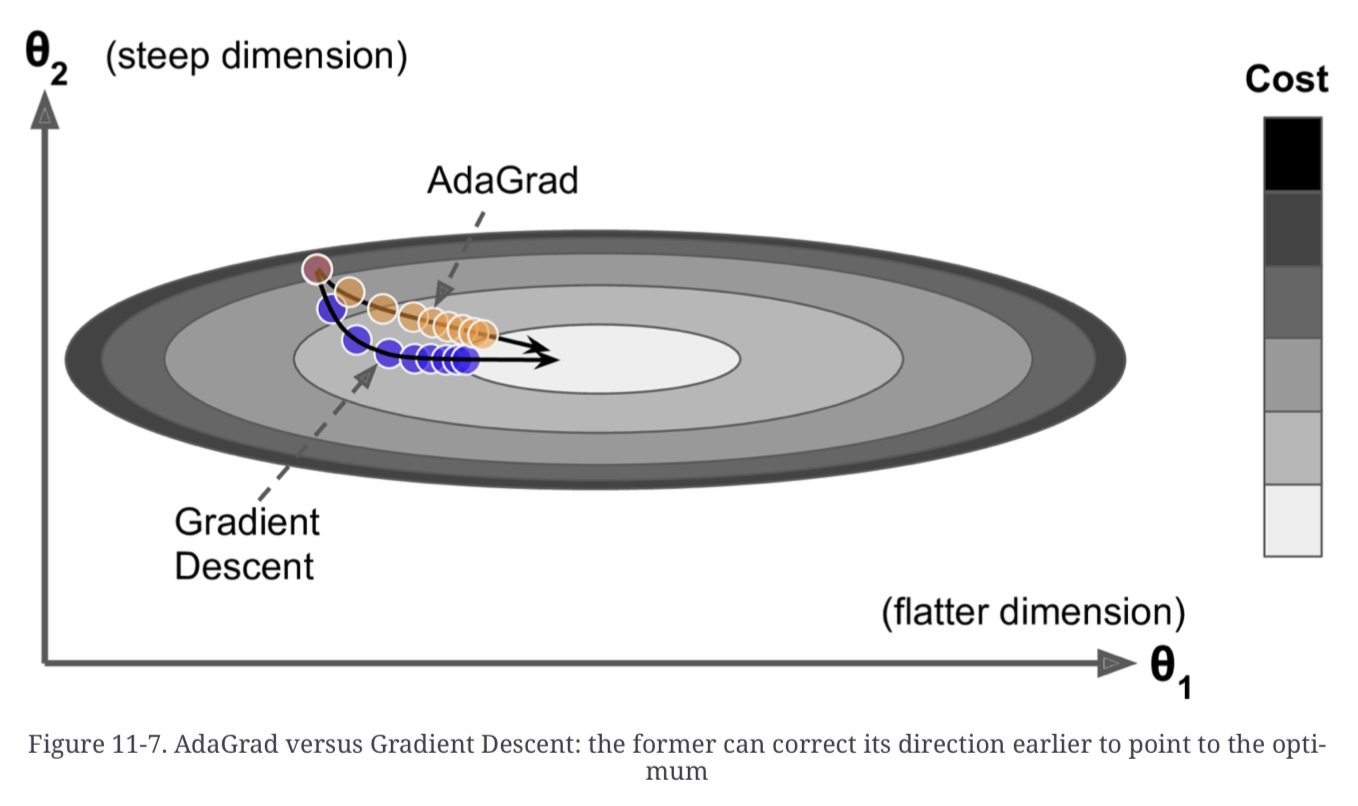

# RMSProp

- Aims to fix AdaGrad's tendency of stopping too early

- Uses exponential decay to only accumulate gradients from more recent iterations

```
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
```
- rho argument default is 0.9 and works well


# Adam and Nadam Optimization
- ADAM = Adaptive Moment Estimation combines RMSProp and Momentum Optimizers
    - https://arxiv.org/abs/1412.6980

- Like momentum optimization:
    - keeps track of an exponentially decaying average of past gradients
- Like RMSProp
    - keeps track of exponentially decaying average of past squared gradients

```
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
```
- beta1 (momentum decay) typically initialized to 0.9
- beta2 (scaling decay) typically initialized to 0.999
- epsilon (smoothing term) defaults to 10-7


## Nadam

 - Adam optimization plus the Nesterov trick
 - faster

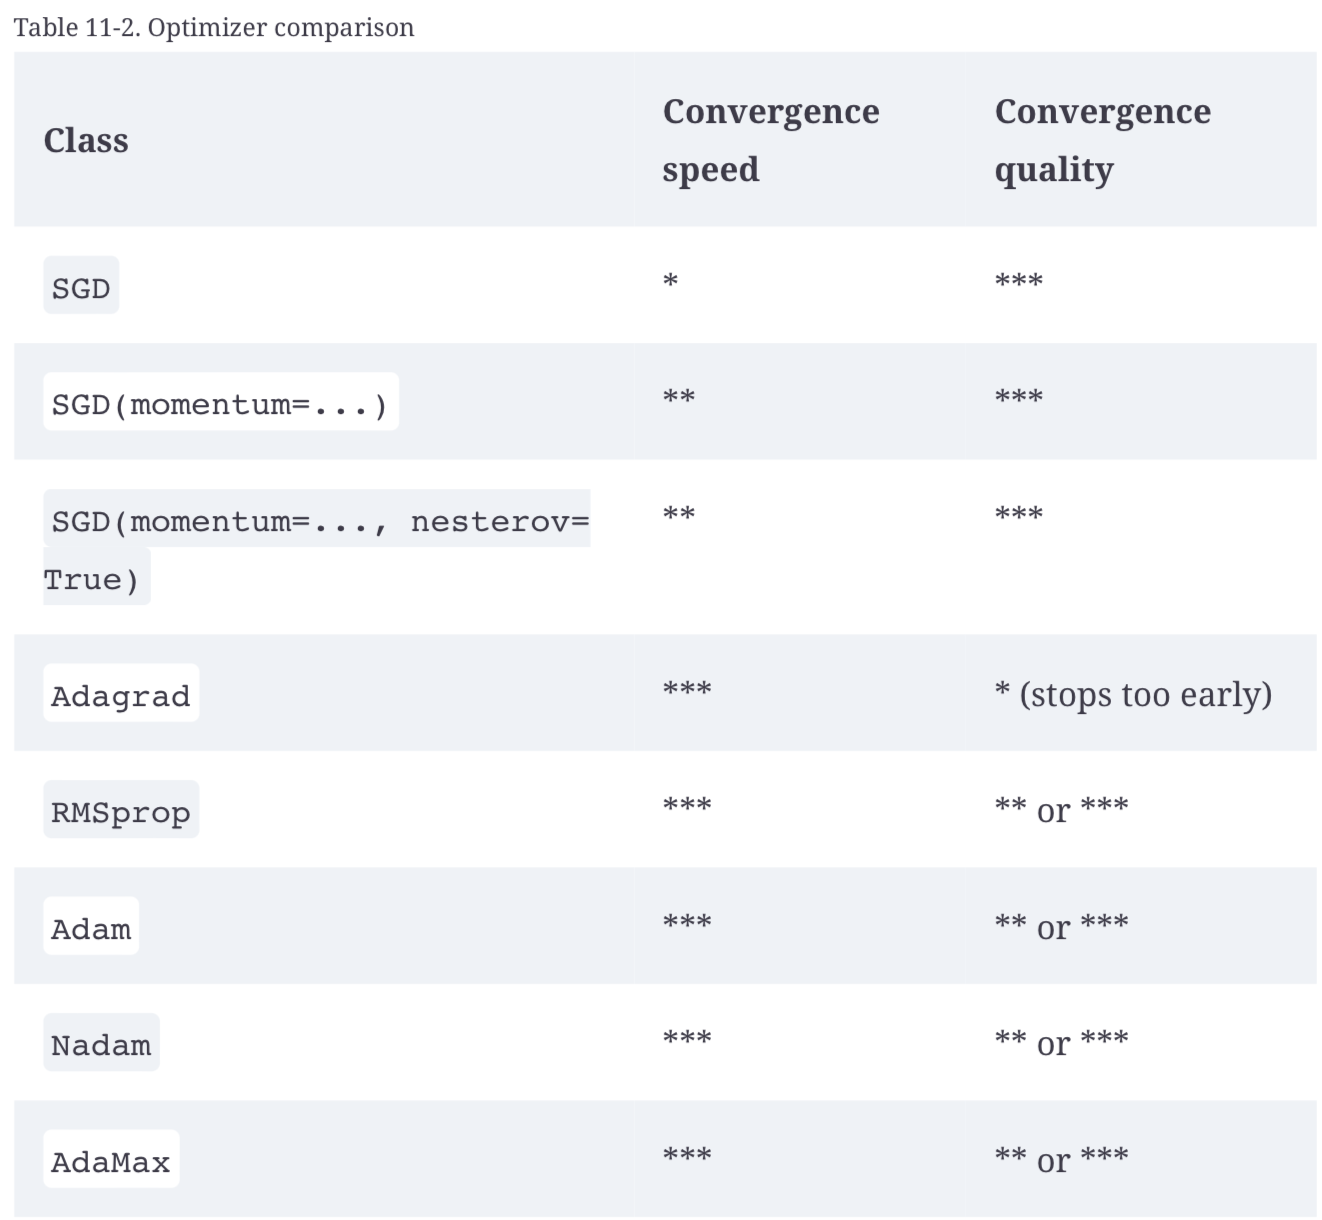

- There are also plenty of algorithms that use hessians (2nd order partial derivative) rather than Jacobians (1st order partial derivative)
    - however since hessians have n^2 params, they cause serious memory issues

# Learning Rate Scheduling

- One way to find the right learning rate is to incrementally increase the rate, and look at the loss curve -- when the loss curve starts to rise again, we stop.
    - A lr slightly lower than this "stopping" number is key

- Can also start with a large learning rate and drop it once training stops making quick progress (this will reach a solution faster)

## Types of Schedules

1. Power Scheduling
    - lr is a funciton of the iteration number (t)
    - η(t) = η0 / (1 + t/s)c
        - η0 is the initial lr
        - c is the power (typically 1)
        - "s" is the steps
        - After "s" steps, the lr is η0 / 2
        - And after "s" more steps the lr is η0 / 3


2. Exponential Scheduling
    - Set the learning rate to η(t) = η0 0.1t/s
    - The lr will gradually drop by a factor of 10 every "s" steps

3. Piecewise constant scheduling
    - Using a constant lr for a number of epochs, then a new constant, etc.

4. Performance scheduling
    - Measure validation error every N steps (like for early stopping)
    - Reduce the lr by a factor of λ when the error stops dropping

5. 1cycle scheduling
    - https://arxiv.org/abs/1803.09820 (2018)
    - Starts by increasing η0 linearly to η1 halfway through training
    - Then decreases it linearly to η0 the second half of training
    - The last few epochs lr is dropped by several orders of magnitude
    - Max lr (η1) is chosen by using same methods as finding the lr we used before
    - η0 is set to be 10x lower than η1

## Implementing Schedules

- The power schedule is easy, set decay to 1/s (c is assumed 1)
```
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)
```

- Exponential and piecewise scheduling is easy too.
    - Implement a function that returns the lr at the current epoch

In [1]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

Then do this:

```
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, [...], callbacks=[lr_scheduler])
```

- The LearningRateScheduler automatically updates the learning rate at each epoch

- These schedules can be found in keras.optimizers.schedules

# Avoid Overfitting With Regularization

- Early stopping is the best

- To constrain a NNs connection weights we can use l2 reg
- To create a sparse model (many weights = 0), we can use l1 reg
- Use keras.regularizers
```
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# for l1: keras.regularizers.l1()
# for both: keras.regularizers.l1_l2()
```

For max reusability we can use **functools.partial**, which lets you create a thin wrapper around any obect and define defaults

```
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
```

# Dropout

- Highly effective for large models
- At every epoch (e), every neuron has probability (p) of shutting off
    - including inputs, excluding output neurons
    - hyperparam "p" is the dropout rate which defines "p"
- Dropout is like having a unique neural network at each training step
    -  there are 2^N possible networks (N is the number of droppable neurons)
- The resulting neural network is an averaging ensemble of all these smaller neural networks

### During Testing

- We should multiply our outputs by (1-p)
- If we don't then our neurons would be getting extra input signal that it didn't have during training
- Or we can divide each neuron’s output by "p" during training 

## Monte Carlo (MC) Dropout

- Implementation is below
```
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
```
- Note that the model.__ call__ method is like model.predict except that it returns the tensor and supports the training argument (which lets us use dropout layers).
- We do that for N epochs (which is like doing it for N "child" models) 
- We take the outputs, stack them, and take an average
- This gives us a monte carlo estimate that is often more reliable than our single prediction with dropout layers turned off


- we can also subclass dropout to create this
```
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
```


